In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# plot table
import texttable as tt

def plotTable(headers,
              rows,
              valign=True,
              column_width=False,
              no_deco=False,
              precision=1):
    tab = tt.Texttable()
    if len(headers) > 0:
        tab.header(headers)
    tab.set_precision(precision)
    for row in rows:
        tab.add_row(row)

    if valign and len(headers) > 0:
        tab.set_cols_valign(['m'] * len(headers))

    if column_width:
        columns = [0] * len(rows[0])
        for row in rows:
            for i, cell in enumerate(row):
                if isinstance(row[i], str):
                    columns[i] = max(
                        columns[i],
                        max([len(line) for line in row[i].split('\n')]))
        for i, head in enumerate(headers):
            columns[i] = max(columns[i], len(head))
        tab.set_cols_width(columns)

    if no_deco:
        tab.set_deco(tt.Texttable.HEADER | tt.Texttable.VLINES)

    s = tab.draw()
    return s

def data_from_file(file_name,case):
    #case = 1-> Id from file. Iq in 0->220 > 'i_direct_flux'
    #case = 2 -> Iq from file. Id in 0->220 > 'j_q_flux'
    data = np.loadtxt(file_name)
    ids = data[0, :]    
    dfs = data[1:, :]
    iqs = list(range(220, -1, -20))
    if case == 1:
        xLabel = 'Id'
        yLabel = 'direct flux'
        Is = 'Iq'
    elif case == 2:
        xLabel = 'Iq'
        yLabel = 'quadratic flux'  
        Is = 'Id'
    return ids, dfs, iqs, xLabel, yLabel, Is


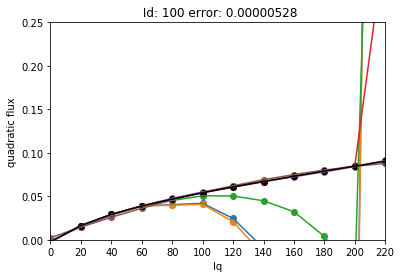

+---------+-----------+-----------+-----------+----------+----------+----------+
|   Id    | y=f(x**7) | y=f(x**6) | y=f(x**5) | y=f(x**4 | y=f(x**3 | y=f(x**2 |
|         |           |           |           |    )     |    )     |    )     |
+=========+===========+===========+===========+==========+==========+==========+
| Id: 220 | 0.000     | 0.000     | 0.000     | 0.000    | 0.000    | 0.005    |
+---------+-----------+-----------+-----------+----------+----------+----------+
| Id: 200 | 0.000     | 0.000     | 0.000     | 0.000    | 0.000    | 0.008    |
+---------+-----------+-----------+-----------+----------+----------+----------+
| Id: 180 | 0.000     | 0.000     | 0.000     | 0.000    | 0.001    | 0.011    |
+---------+-----------+-----------+-----------+----------+----------+----------+
| Id: 160 | 0.000     | 0.000     | 0.000     | 0.000    | 0.001    | 0.017    |
+---------+-----------+-----------+-----------+----------+----------+----------+
| Id: 140 | 0.000     | 0.00

In [2]:
# approximate de curve with different elementary fucntions
ids, dfs, iqs, xLabel, yLabel, Is = data_from_file('j_q_flux', 2)

def func_ord_7(x, h ,g, f, e, a, b, c, d):
    return h * (x ** 7) + g * (x ** 6) + f * (x ** 5) + e * (x **4) + a * (x**3) + b * (x ** 2) + c * x + d

def func_ord_6(x, g, f, e, a, b, c, d):
    return g * (x ** 6) + f * (x ** 5) + e * (x **4) + a * (x**3) + b * (x ** 2) + c * x + d

def func_ord_5(x, f, e, a, b, c, d):
    return f * (x ** 5) + e * (x **4) + a * (x**3) + b * (x ** 2) + c * x + d

def func_ord_4(x, e, a, b, c, d):
    return e * (x **4) + a * (x**3) + b * (x ** 2) + c * x + d

def func_ord_3(x, a, b, c, d):
    return a * (x**3) + b * (x ** 2) + c * x + d

def func_ord_2(x, a, b, c):
    return a * (x**2) + b * x  + c
  
def plot_original(iq_idx):
    df = dfs[:, iq_idx]    
    # plot original points     
    plt.plot(ids, df, label = 'original', color = 'black')
    plt.scatter(ids, df, color = 'black')

def plot_curve_iq(iq_idx, func, func_descr='', label='', plot=False):
    df = dfs[:, iq_idx]    
    # fit curve to points     
    w, pcov = curve_fit(func, ids, df, )
    
    # compute error
    df_pred = func(ids, *w)
    error = (1 / len(ids)) * sum((df_pred - df) ** 2)
    
    # predict new points     
    x = np.arange(0, 240, 20)
    y_pred = func(x, *w)
    
    if plot:
        plt.plot(x, y_pred,label = label)
        plt.scatter(x, y_pred)
        plt.title(' %s error: %.8f' % (func_descr, error))
        plt.ylim([0, 0.25])
        plt.xlim([0, 220])
        plt.xticks(ids)
        plt.xlabel(xLabel)
        plt.ylabel(yLabel)
        #plt.grid()
        #plt.show()
    return error
        
funcs = [
    func_ord_7,
    func_ord_6, 
    func_ord_5, 
    func_ord_4, 
    func_ord_3, 
    func_ord_2
]
dex = {
    func_ord_7 : 'y=f(x**7)',
    func_ord_6 : 'y=f(x**6)',
    func_ord_5 : 'y=f(x**5)', 
    func_ord_4 : 'y=f(x**4)',
    func_ord_3 : 'y=f(x**3)',
    func_ord_2 : 'y=f(x**2)',
}

curve_indices = list(range(0, 12)) 
curve_for_plot = [6]

# Get current size
#plt.rcParams["figure.figsize"] = [12, 8]
    
headers = ['%s ' %Is] + [dex[func] for func in funcs]
rows    = []

for curve_idx in curve_indices:
    row = ['%s: %d' % (Is,iqs[curve_idx])]
    toPlot = curve_idx in curve_for_plot
    for func in funcs:
        error = plot_curve_iq(curve_idx, func, '%s: %d' % (Is, iqs[curve_idx]), dex[func], plot=toPlot)
        row.append(error * 10000)
    rows.append(row)
        
    if toPlot:
        plot_original(curve_idx)
        plt.show()
#     plt.grid()
#     plt.legend(loc='best')

table = plotTable(headers=headers, rows=rows, precision=3)
print(table)

Id: 200, pts num: 6


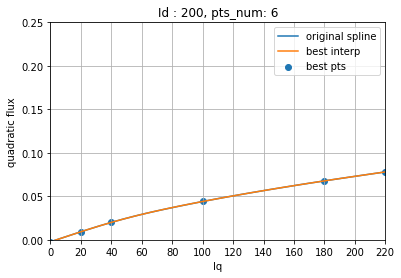

Id: 200, pts num: 5


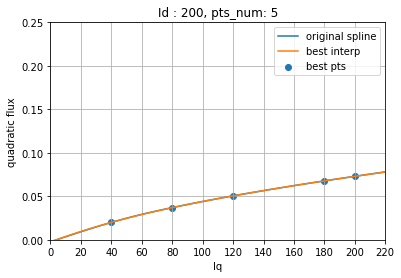

Id: 200, pts num: 4


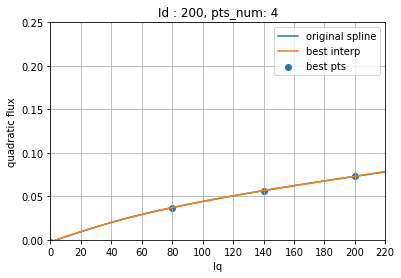

Id: 160, pts num: 6


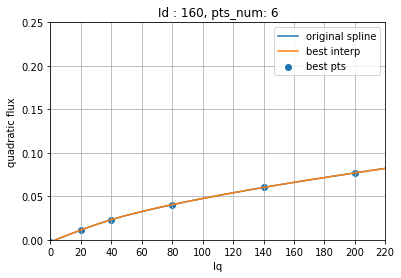

Id: 160, pts num: 5


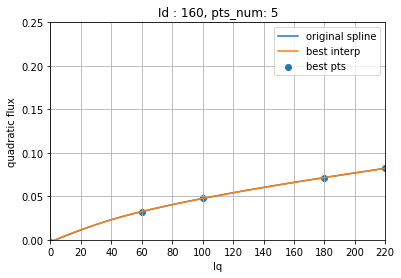

Id: 160, pts num: 4


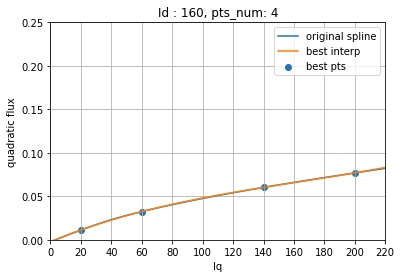

Id: 120, pts num: 6


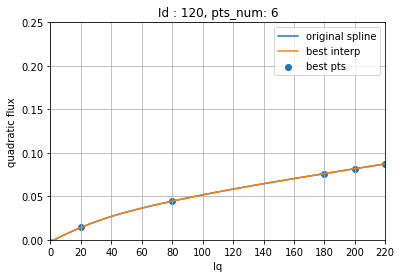

Id: 120, pts num: 5


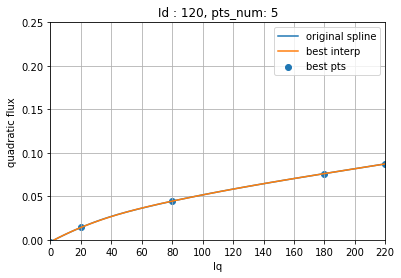

Id: 120, pts num: 4


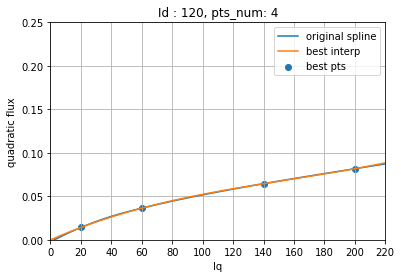

Id: 80, pts num: 6


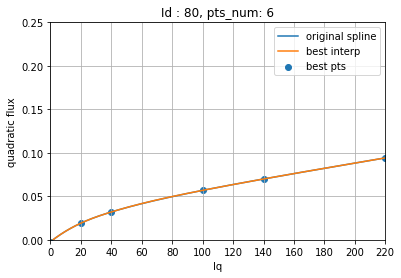

Id: 80, pts num: 5


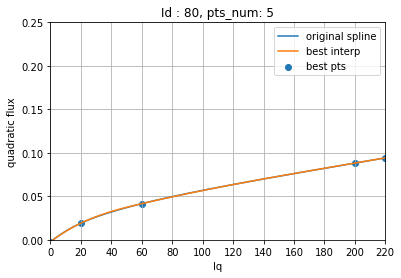

Id: 80, pts num: 4


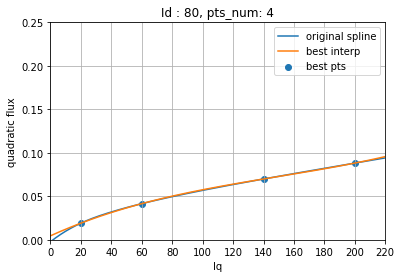

Id: 40, pts num: 6


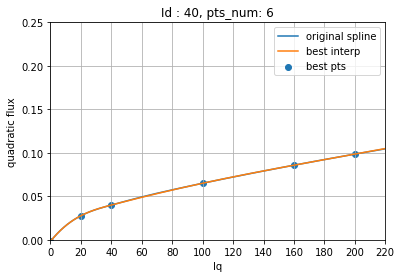

Id: 40, pts num: 5


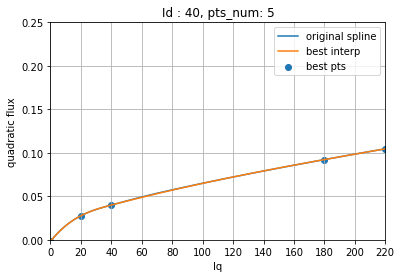

Id: 40, pts num: 4


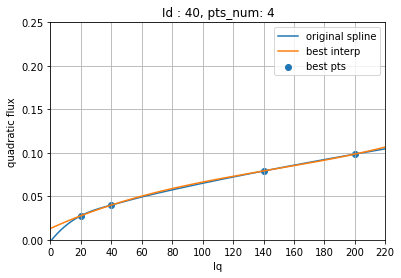

Id: 0, pts num: 6


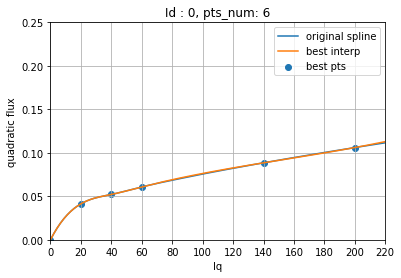

Id: 0, pts num: 5


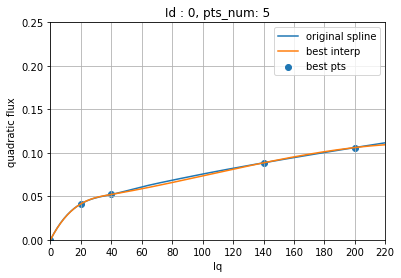

Id: 0, pts num: 4


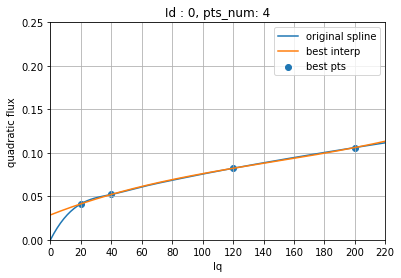

Interpolation error ( sum squared error * 10 ^ 6)
+--------+-------------+------------+------------+------------+------------+------------+------------+--------------------------------+
|   Id   | pts num: 10 | pts num: 9 | pts num: 8 | pts num: 7 | pts num: 6 | pts num: 5 | pts num: 4 |  ######### 5_best_pts ######## |
+========+=============+============+============+============+============+============+============+================================+
| Id 220 | 0.00000     | 0.00001    | 0.00002    | 0.00012    | 0.00065    | 0.01706    | 0.03920    | [ 40.  80. 160. 180. 220.]     |
+--------+-------------+------------+------------+------------+------------+------------+------------+--------------------------------+
| Id 200 | 0.00000     | 0.00004    | 0.00019    | 0.00032    | 0.00060    | 0.01437    | 0.04685    | [ 40.  80. 120. 180. 200.]     |
+--------+-------------+------------+------------+------------+------------+------------+------------+--------------------------------

In [27]:
#cubic spline interpolation

from scipy.interpolate import interp1d
from scipy import interpolate
import itertools
import sys

#ids, dfs, iqs, xLabel, yLabel, Is = data_from_file('i_direct_flux', 1)

def sum_squared_error(gr, pred):
    gr = np.array(gr)
    pred = np.array(pred)
    return (10 ** 6) * (1 / gr.shape[0]) * sum((gr - pred) ** 2)

#curve_indices = list(range(0, 12)) 
curves_for_plot = list(range(1, 13,2))
pts_for_plot = [6,5,4]

# try interpolating with only 10, 9, 8 ... 4, 3 points
sub_points_num  = list(range(len(ids)-2, 3, -1))

headers = ['%s' %Is] + ['pts num: %d' % pts for pts in sub_points_num] + [' ######### 5_best_pts ########']
rows = []

for curve in curve_indices:
    y = dfs[:, curve]
    x = ids
        
    tck = interpolate.splrep(x, y, s=0)
    x_new = np.linspace(min(x), max(x), 200)
        
    # baseline = y values obtained when interpolating with all ground truth points
    baseline = interpolate.splev(x_new, tck, der=0)
    
    row = ['%s %d' % (Is, iqs[curve])]
    best_5_pts = []

    for points_num in sub_points_num:
        # store best configuration
        best_pts     = (x, y)
        best_interp  = (x_new, baseline)
        best_error   = sys.float_info.max
        best_err_gr  = sys.float_info.max
    
        sub_points_sets = itertools.combinations(range(len(ids)), points_num)
        for pts in sub_points_sets:
            pts = list(pts)
            x_     = x[pts]
            y_     = y[pts]
            tck_   = interpolate.splrep(x_, y_, s=0)
            y_new_ = interpolate.splev(x_new, tck_, der=0)            
        
            # error -- difference between baseline interp curve and current one
            error = sum_squared_error(baseline, y_new_)
            
            if error < best_error:
                best_error  = error
                best_pts    = (x_, y_)
                best_interp = (x_new, y_new_)
                
                # interpolate in target points + evaluate error
                gr_interp = interpolate.splev(x, tck_, der=0)
                best_err_gr = sum_squared_error(y, gr_interp)
        
        if points_num == 5:
            best_5_pts = best_pts[0]
            
        row.append(best_err_gr)
        
        if curve in curves_for_plot and points_num in pts_for_plot:
            print('%s: %d, pts num: %d' % (Is,iqs[curve], points_num))
            plt.clf()
            #plt.scatter(x, y, label='orig points')
            plt.plot(x_new, baseline, label='original spline')
            plt.scatter(best_pts[0], best_pts[1], label='best pts')
            plt.plot(best_interp[0], best_interp[1], label='best interp')

            plt.ylim([0, 0.25])
            plt.xlim([0, 220])
            plt.xticks(ids)
            plt.xlabel(xLabel)
            plt.ylabel(yLabel)
            plt.legend(loc='best')
            plt.title('%s : %d, pts_num: %d' % (Is,iqs[curve], points_num))
            plt.grid()
            plt.show()
    
    row.append(best_5_pts)
    rows.append(row)

print('Interpolation error ( sum squared error * 10 ^ 6)')
table = plotTable(headers=headers, rows=rows, column_width=True, precision=5)
print(table)